## 1. Import Libraries

In [1]:
import os
import json
import copy
import random
import math
import itertools
import functools
from collections import defaultdict, Counter
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
%matplotlib inline

from tqdm.notebook import tqdm

from PIL import Image

## 2. ARC Problem: [Reframing and Initial Tweaks]
###  Re-framing Part-1:
Tweak 1:
> Motivation:
  * The input and output images are bound by 30 pixels in height and width each.
  * If we add an eleventh color which signifies blank pixels in the 30 x 30 grid that reduces the problem a bit.
  * So what would happen essentially is that, the input and outputs are always 30x30 grids with a new eleventh color introduced which means those places are blank.
  * We have to specifiy the unique starting point for every image, for that we take the left bottom corner of every image as the (0,0) element of the grid and fill accordingly.  

In [2]:
class ARCDataset:
    def __init__(self, train_path=None, train_solutions_path=None, test_path=None, eval_path=None, eval_solutions_path=None):
        self.train_data = self._load_json(train_path) if train_path else {}
        self.train_solutions = self._load_json(train_solutions_path) if train_solutions_path else {}
        self.test_data = self._load_json(test_path) if test_path else {}
        self.eval_data = self._load_json(eval_path) if eval_path else {}
        self.eval_solutions = self._load_json(eval_solutions_path) if eval_solutions_path else {}

        self.ARC_COLORMAP = colors.ListedColormap([
            '#301934', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
            '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#000000'  # 11th color for blank
        ])
        self.ARC_NORM = colors.Normalize(vmin=0, vmax=11)

    def _load_json(self, path):
        with open(path, 'r') as f:
            return json.load(f)

    def get_task(self, task_id, split='train'):
        if split == 'train':
            return self.train_data.get(task_id), self.train_solutions.get(task_id)
        elif split == 'test':
            return self.test_data.get(task_id), None
        elif split == 'eval':
            return self.eval_data.get(task_id), self.eval_solutions.get(task_id)
        else:
            raise ValueError("split must be 'train', 'test', or 'eval'")

    def resize_grid_to_30x30(self, grid):
        new_grid = [[10] * 30 for _ in range(30)]
        original_height = len(grid)
        original_width = len(grid[0])
        for i in range(original_height):
            for j in range(original_width):
                new_grid[30 - original_height + i][j] = grid[i][j]
        return new_grid

    def revert_from_30x30(self, grid):
        non_blank_rows = [i for i, row in enumerate(grid) if any(cell != 10 for cell in row)]
        non_blank_cols = [j for j in range(len(grid[0])) if any(row[j] != 10 for row in grid)]
        min_row, max_row = min(non_blank_rows), max(non_blank_rows)
        min_col, max_col = min(non_blank_cols), max(non_blank_cols)
        return [row[min_col:max_col + 1] for row in grid[min_row:max_row + 1]]

    def create_tweaked_training_data(self, task_data):
        tweaked_inputs = [self.resize_grid_to_30x30(example['input']) for example in task_data.get('train', [])]
        tweaked_outputs = [self.resize_grid_to_30x30(example['output']) for example in task_data.get('train', [])]
        return tweaked_inputs, tweaked_outputs

    def create_tweaked_unsolved_input(self, task_data):
        test_examples = task_data.get('test', [])
        if not test_examples:
            raise ValueError("No test examples found in task data.")
        return self.resize_grid_to_30x30(test_examples[0]['input'])

    def plot_raw_task(self, task_data, task_solution, title="Raw Task Visualization"):
        train_examples = task_data.get('train', [])
        test_examples = task_data.get('test', [])
        num_train = len(train_examples)
        num_test = len(test_examples)
        wn = num_train + num_test
        fig, axs = plt.subplots(2, wn, figsize=(2.5*wn, 5))
        plt.suptitle(title, fontsize=16)
        # Plot train inputs/outputs
        for j, example in enumerate(train_examples):
            axs[0, j].imshow(example['input'], cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[0, j].set_title(f"train input {j+1}")
            axs[0, j].axis('off')
            axs[1, j].imshow(example['output'], cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[1, j].set_title(f"train output {j+1}")
            axs[1, j].axis('off')
        # Plot test inputs/outputs
        for k, example in enumerate(test_examples):
            idx = num_train + k
            axs[0, idx].imshow(example['input'], cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[0, idx].set_title(f"test input {k+1}")
            axs[0, idx].axis('off')
            if task_solution and k < len(task_solution):
                axs[1, idx].imshow(task_solution[k], cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
                axs[1, idx].set_title(f"test output {k+1}")
                axs[1, idx].axis('off')
        plt.tight_layout()
        plt.show()

    def plot_tweaked_task(self, task_data, task_solution, title="Tweaked Task Visualization"):
        train_examples = task_data.get('train', [])
        test_examples = task_data.get('test', [])
        num_train = len(train_examples)
        num_test = len(test_examples)
        wn = num_train + num_test
        fig, axs = plt.subplots(2, wn, figsize=(2.5*wn, 5))
        plt.suptitle(title, fontsize=16)
        # Plot tweaked train inputs/outputs
        for j, example in enumerate(train_examples):
            tweaked_input = self.resize_grid_to_30x30(example['input'])
            tweaked_output = self.resize_grid_to_30x30(example['output'])
            axs[0, j].imshow(tweaked_input, cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[0, j].set_title(f"tweaked train input {j+1}")
            axs[0, j].axis('off')
            axs[1, j].imshow(tweaked_output, cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[1, j].set_title(f"tweaked train output {j+1}")
            axs[1, j].axis('off')
        # Plot tweaked test inputs/outputs
        for k, example in enumerate(test_examples):
            idx = num_train + k
            tweaked_input = self.resize_grid_to_30x30(example['input'])
            axs[0, idx].imshow(tweaked_input, cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
            axs[0, idx].set_title(f"tweaked test input {k+1}")
            axs[0, idx].axis('off')
            if task_solution and k < len(task_solution):
                tweaked_output = self.resize_grid_to_30x30(task_solution[k])
                axs[1, idx].imshow(tweaked_output, cmap=self.ARC_COLORMAP, norm=self.ARC_NORM)
                axs[1, idx].set_title(f"tweaked test output {k+1}")
                axs[1, idx].axis('off')
        plt.tight_layout()
        plt.show()

    def convert_to_dataframes(self, tweaked_inputs, tweaked_outputs, tweaked_test_inputs):
        """
        Converts lists of grids to Pandas DataFrames without recoloring.

        Parameters:
        - tweaked_inputs: List of tweaked input grids (30x30).
        - tweaked_outputs: List of tweaked output grids (30x30).
        - tweaked_test_inputs: List of tweaked test input grids (30x30), or a single grid.

        Returns:
        - List of DataFrames for all inputs, outputs, and test inputs.
        """
        def grid_to_dataframe(grid):
            return pd.DataFrame(grid, index=range(29, -1, -1), columns=range(30))

        # Ensure tweaked_test_inputs is always a list
        if isinstance(tweaked_test_inputs, (list, tuple)) and len(tweaked_test_inputs) > 0 and isinstance(tweaked_test_inputs[0][0], (list, tuple)):
            test_input_grids = tweaked_test_inputs
        else:
            test_input_grids = [tweaked_test_inputs]

        input_dataframes = [grid_to_dataframe(grid) for grid in tweaked_inputs]
        output_dataframes = [grid_to_dataframe(grid) for grid in tweaked_outputs]
        test_input_dataframes = [grid_to_dataframe(grid) for grid in test_input_grids]

        return input_dataframes + output_dataframes + test_input_dataframes 

* Load and Plot the actual porblem statement

In [3]:
DATA_PATH = '/kaggle/input/arc-prize-2025'
dataset = ARCDataset(
    train_path=f'{DATA_PATH}/arc-agi_training_challenges.json',
    train_solutions_path=f'{DATA_PATH}/arc-agi_training_solutions.json',
    test_path=f'{DATA_PATH}/arc-agi_test_challenges.json',
    eval_path=f'{DATA_PATH}/arc-agi_evaluation_challenges.json',
    eval_solutions_path=f'{DATA_PATH}/arc-agi_evaluation_solutions.json',
)
task_data, task_solution = dataset.get_task('025d127b', split='train')

*  The first row contains all the input images, the second row contains all output images. The third row is the question input.

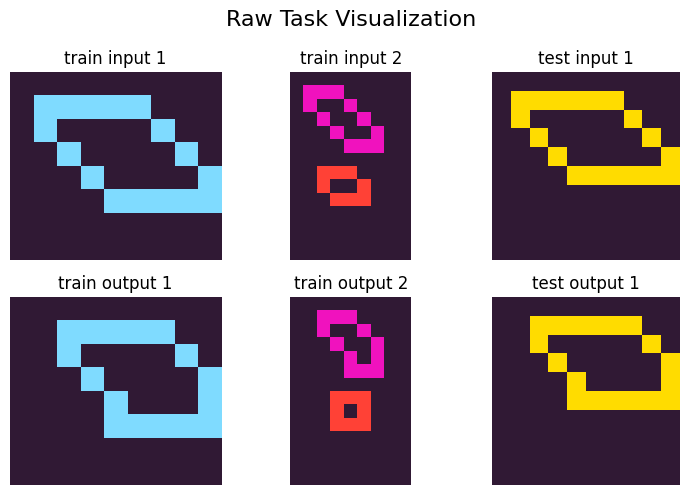

In [4]:
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")

* Now the same format for the uniform version of the problem in terms of grid size.

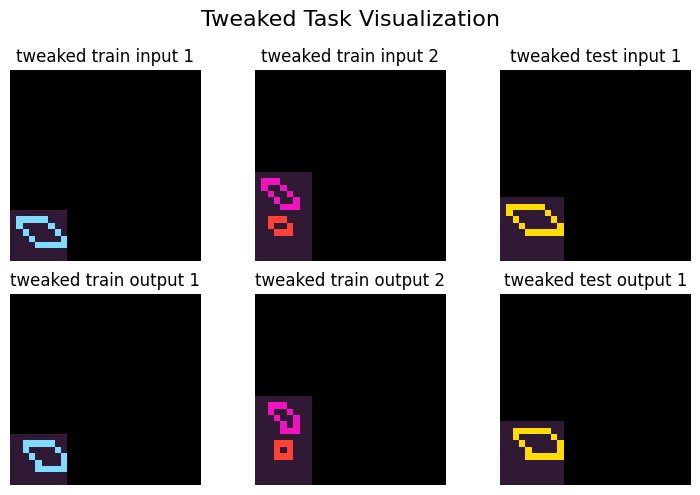

In [5]:
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

* 5 more example cases

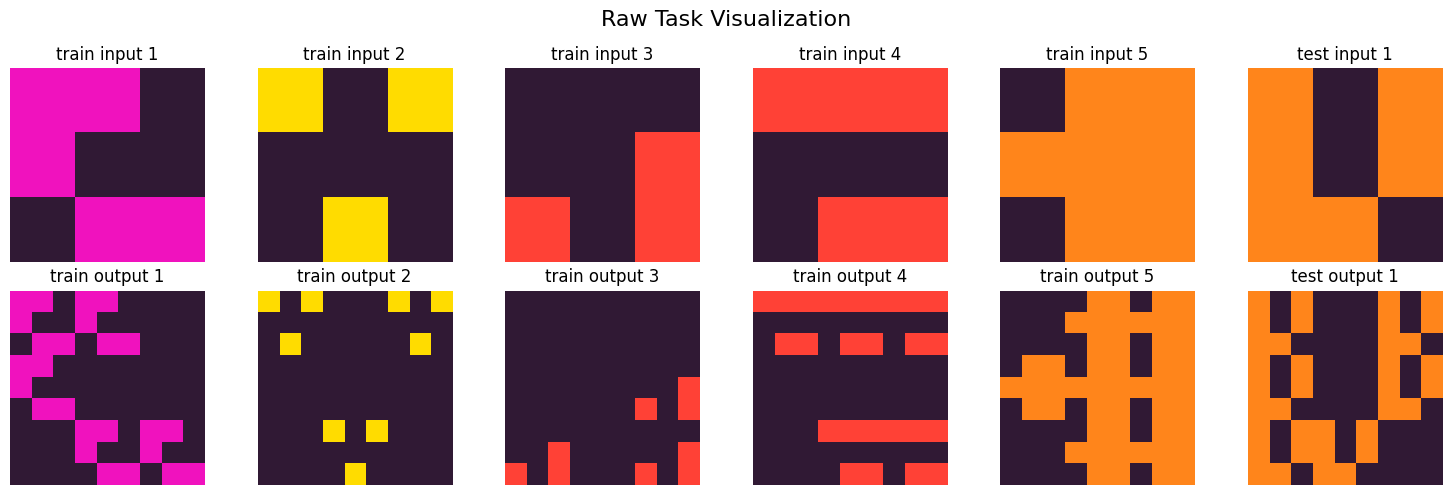

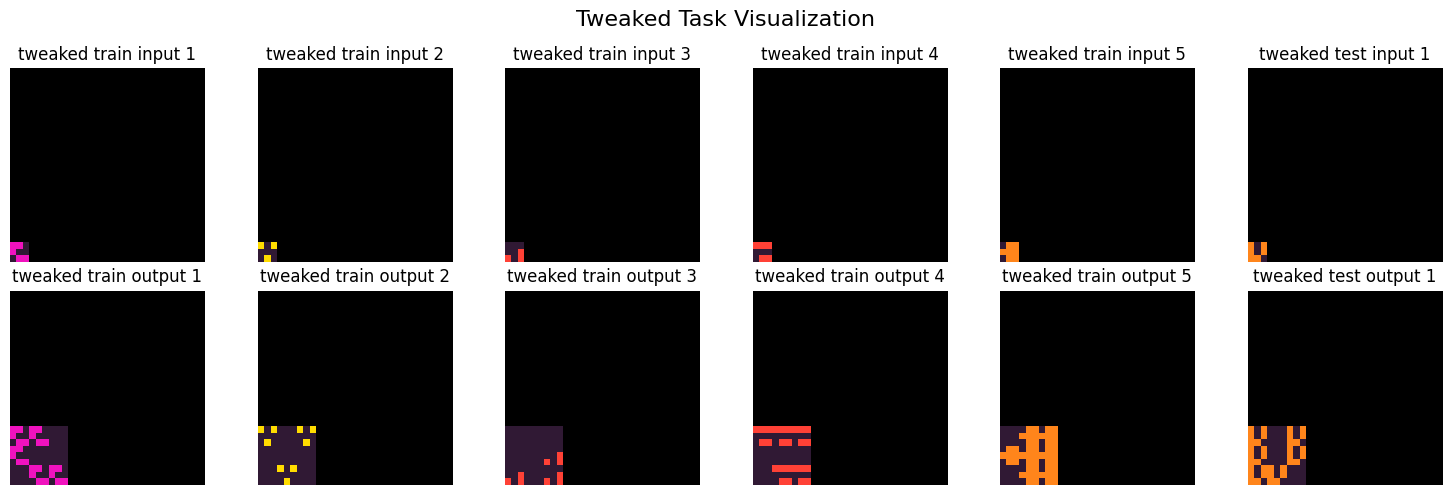

In [6]:
task_data, task_solution = dataset.get_task('007bbfb7', split='train')
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

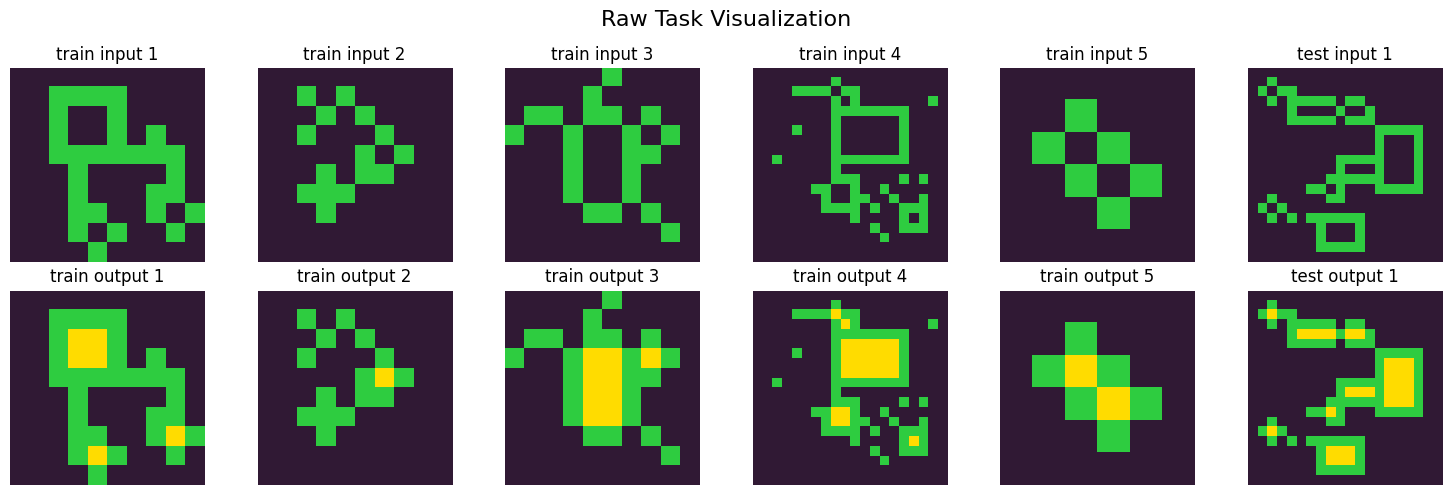

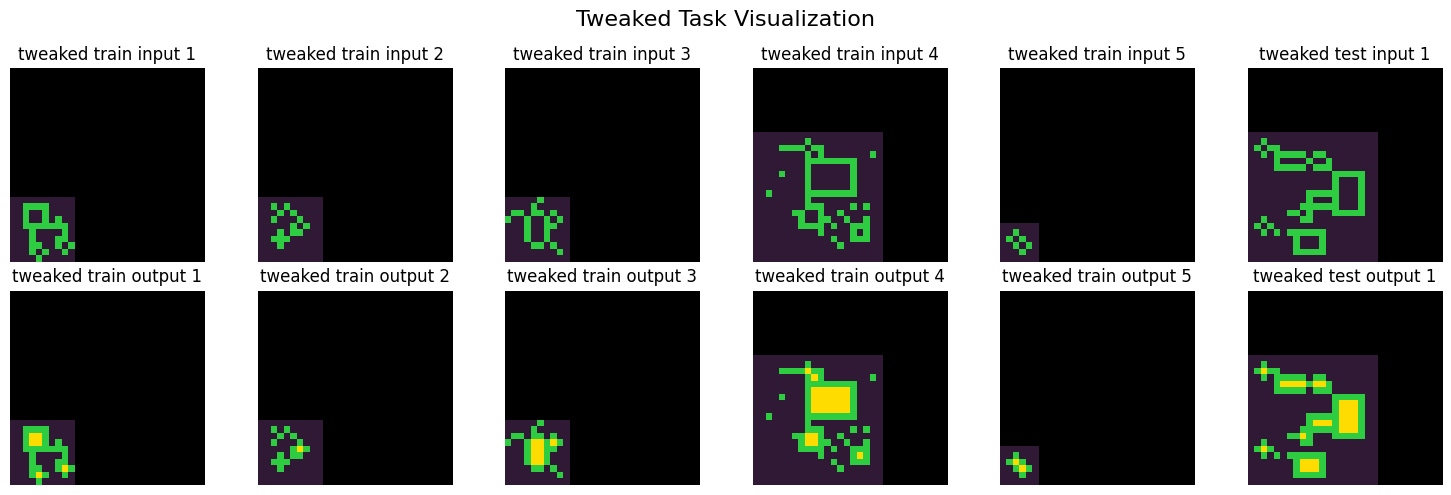

In [7]:
task_data, task_solution = dataset.get_task('00d62c1b', split='train')
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

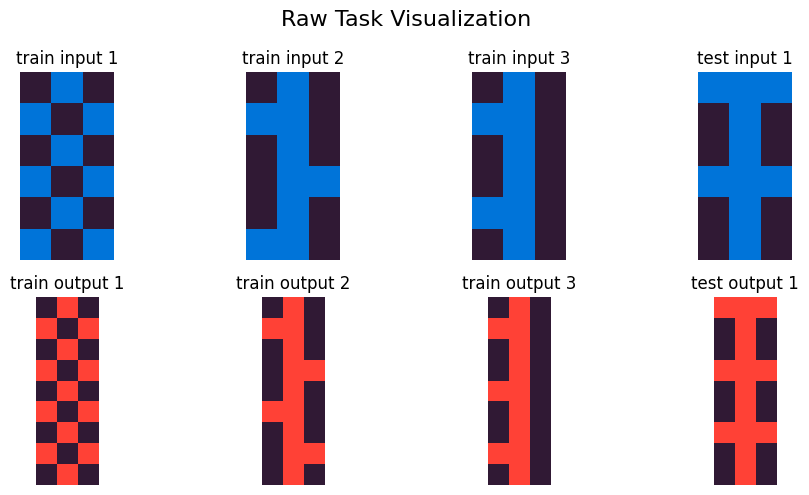

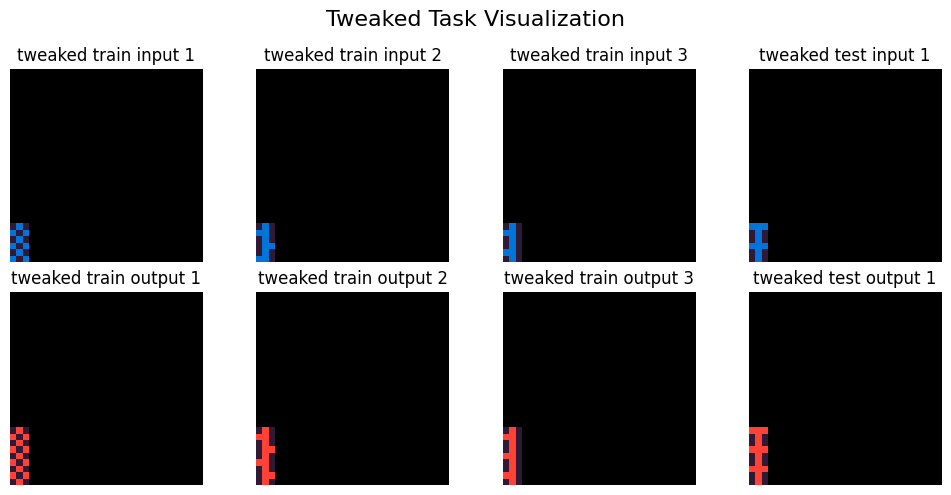

In [8]:
task_data, task_solution = dataset.get_task('017c7c7b', split='train')
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

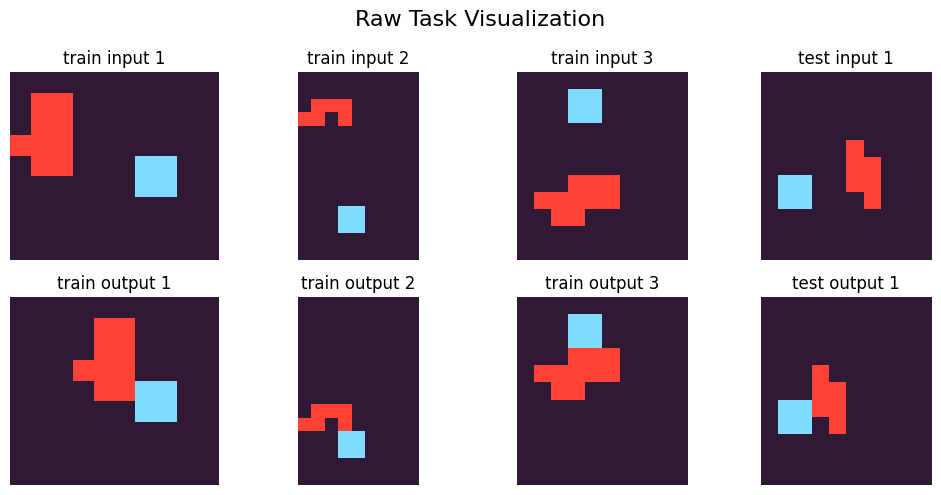

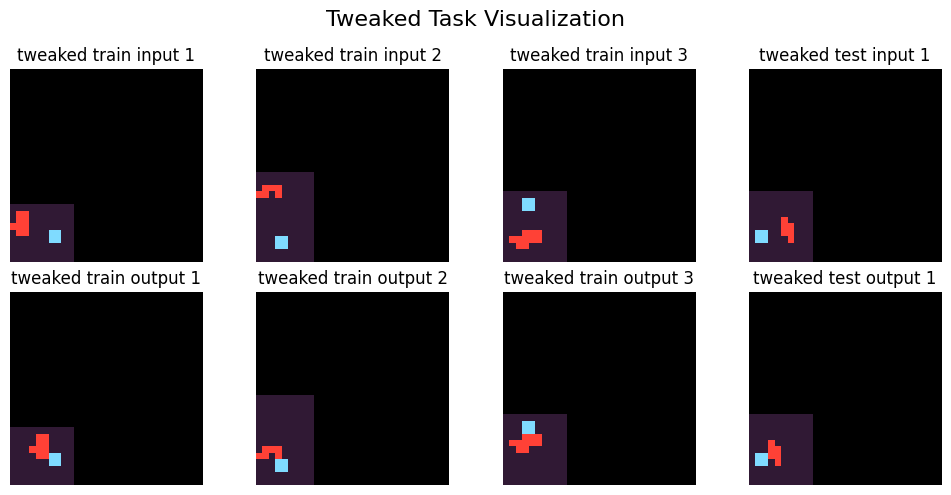

In [9]:
task_data, task_solution = dataset.get_task('05f2a901', split='train')
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

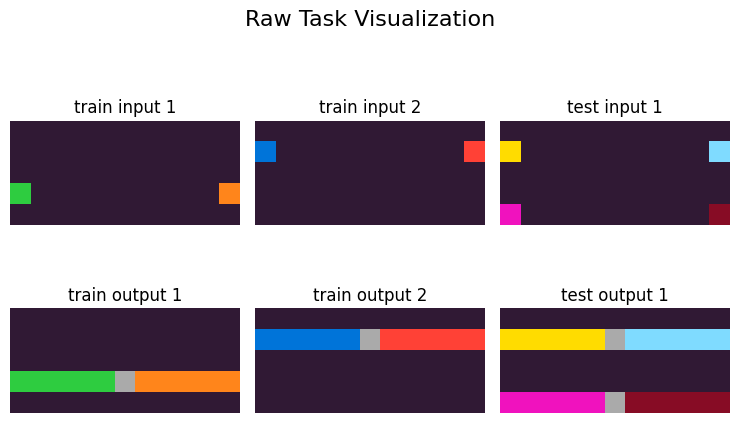

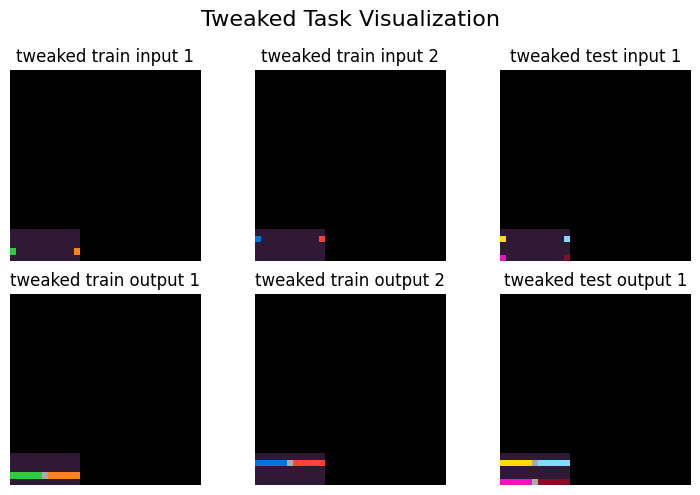

In [10]:
task_data, task_solution = dataset.get_task('29c11459', split='train')
dataset.plot_raw_task(task_data, task_solution, title="Raw Task Visualization")
dataset.plot_tweaked_task(task_data, task_solution, title="Tweaked Task Visualization")

In [11]:
tweaked_inputs, tweaked_outputs = dataset.create_tweaked_training_data(task_data)
tweaked_test_input = dataset.create_tweaked_unsolved_input(task_data)

###  Re-framing Part-2:
Tweak 2 [Needs more work]:
> Motivation:
  *  For each pair create a uniform color code, that is even if the colors are different, we do the nomenclature by first the most populated pixel on each picture as Color1, and so on, such that we can use the pair as one to fetch patterns
  *  The output from this part would be matrices encoding the same images.

In [12]:
dataframes = dataset.convert_to_dataframes(tweaked_inputs, tweaked_outputs, tweaked_test_input)

In [13]:
# Access each DataFrame
input_df1 = dataframes[0]
input_df2 = dataframes[1]
output_df1 = dataframes[2]
output_df2 = dataframes[3]
test_input_df = dataframes[4]

In [14]:
# Display the first input DataFrame
print("Input DataFrame 1:")
input_df1

Input DataFrame 1:


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
29,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
28,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
27,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
26,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
25,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
24,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
23,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
22,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
21,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
20,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


### * So far so good, in the next part I will try to sketch out an idea, still in works, might need a few more coffee sessions .